# Fitting photometric observational data with Bagpipes

This example will take you through fitting photometric data with Bagpipes. This is in many respects simpler than fitting spectroscopy, which is covered in the fifth example. You can find further information on the [fitting observational data](http://bagpipes.readthedocs.io/en/latest/fitting_galaxies.html) page of the documentation.

## Setting up

First we're going to need to load up the observational data a galaxy object, as demonstrated in Example 2:

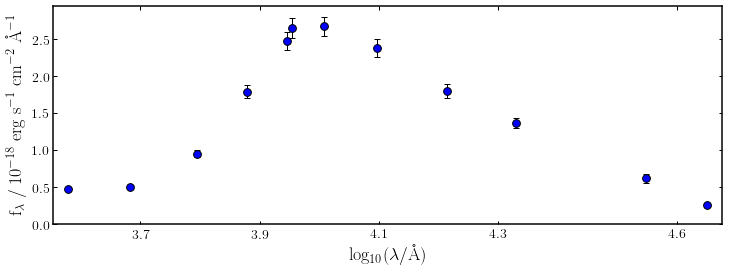

In [2]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits

def load_uvista(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    hdulist = np.loadtxt("UltraVISTA_catalogue.cat",
                         usecols=(0,3,4,5,6,7,8,9,10,11,12,13,14,15,
                                  16,17,18,19,20,21,22,23,24,25,26))

    # Check the object is in the catalogue.
    if np.min(np.abs(hdulist[:,0] - int(ID))) != 0:
        sys.exit("Object not found in catalogue")

    tablerow = np.argmin(np.abs(hdulist[:,0] - int(ID)))

    # Extract the object we're interested in from the catalogue.
    phot_fluxes = hdulist[tablerow, 1:13]
    phot_fluxerrs = hdulist[tablerow, 13:25]

    phot = np.zeros(len(phot_fluxes)*2)
    phot.shape = (len(phot_fluxes), 2)
    
    # Convert to microjanskys
    phot[:,0] = phot_fluxes*10**29
    phot[:,1] = phot_fluxerrs*10**29

    # blow up the errors associated with any N/A points in the phot
    for i in range(len(phot)):
        if ((phot[i, 0] == 0. or phot[i, 1] <= 0) 
                or (phot[i, 1] > 0 and -phot[i, 0] >= 2*phot[i, 1])):
            phot[i,:] = [0., 9.9*10**99.]

    return phot


uvista_filt_list = ["uvista/CFHT_u.txt",
                    "uvista/CFHT_g.txt",
                    "uvista/CFHT_r.txt",
                    "uvista/CFHT_i+i2.txt",
                    "uvista/CFHT_z.txt",
                    "uvista/subaru_z",
                    "uvista/VISTA_Y.txt",
                    "uvista/VISTA_J.txt",
                    "uvista/VISTA_H.txt",
                    "uvista/VISTA_Ks.txt",
                    "uvista/IRAC1",
                    "uvista/IRAC2"]

galaxy = pipes.galaxy("96976", load_uvista, spectrum_exists=False, 
                      filt_list=uvista_filt_list)

fig = galaxy.plot()

## The fit instructions dictionary

Next we need to define the parameters of the model we want to fit to the data. We do this by creating a fit instructions dictionary. In many ways this is similar to the model components dictionary from Example 1. However there are a few extra options for defining which parameters we want to fit:

In [2]:
exp = {}                          # Tau-model star-formation history component
exp["age"] = (0.1, 15.)           # Vary age between 100 Myr and 15 Gyr, in practice 
                                  # the code automatically limits this to the age of
                                  # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)           # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)     # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)    # vary Z between 0 and 2.5 Z_oldsolar

dust = {}                         # Dust component
dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)             # Vary Av between 0 and 2 magnitudes

fit_info = {}                     # The fit instructions dictionary
fit_info["redshift"] = (0., 10.)  # Vary observed redshift from 0 to 10
fit_info["exponential"] = exp   
fit_info["dust"] = dust

Now we can pass the galaxy object and the fit_info dictionary into a bagpipes fit object and run the sampler to fit the data. 


Bagpipes: fitting object 96976 with Dynesty


Bagpipes: fitting complete in 511.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.160      0.308      0.466
exponential:tau                0.458      0.639      0.877
exponential:age                2.702      3.714      4.913
exponential:metallicity        0.187      0.326      0.529
exponential:massformed        10.844     10.940     11.023
redshift                       0.853      0.903      0.966




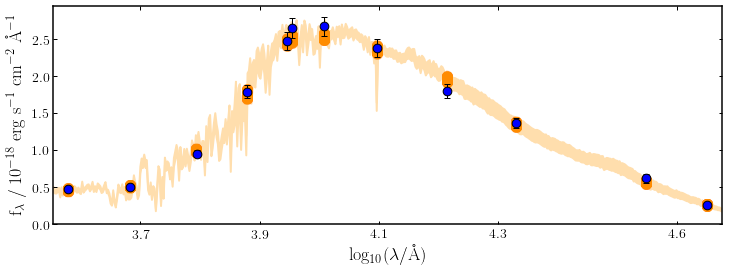

In [4]:
fit = pipes.fit(galaxy, fit_info)

fit.fit()

fig = fit.plot_fit(show=True)

You can now see the orange posterior distribution overlaid on the data, it looks like the fitting went just fine.

## Accessing posterior information

A bunch of useful posterior quantities are dumped into the fit.posterior dictionary:

In [5]:
list(fit.posterior)

['exponential:tau',
 'redshift',
 'lnprob',
 'exponential:metallicity',
 'tmw',
 'mwa',
 'UVJ',
 'samples',
 'log_evidence_err',
 'exponential:age',
 'log_evidence',
 'sfr',
 'dust:Av',
 'sfh',
 'maximum_likelihood',
 'min_chisq_reduced',
 'confidence_interval',
 'median',
 'chosen_samples',
 'mass',
 'min_chisq',
 'exponential:massformed',
 'spectrum_full',
 'photometry',
 'ssfr']

The first dimension of all of these arrays runs over the samples in the posterior.

If we want to know the posterior median living stellar mass we can write:

In [6]:
print np.log10(np.median(fit.posterior["mass"]["total"]["living"]))

10.643072420500111


Or the posterior median star-formation rate and specific star-formation rate:

In [7]:
print np.median(fit.posterior["sfr"]), np.log10(np.median(fit.posterior["sfr"]/fit.posterior["mass"]["total"]["living"]))

0.4521535022353793 -10.985366251723116


Or the confidence interval on the mass-weighted age:

In [8]:
print np.percentile(fit.posterior["mwa"], (16,84))

[2.23996214 3.97098088]


Saving and loading posteriors
-----------------------------------

When a fit is finished, basic outputs are saved as a hdf5 file in the "pipes/posterior" dictionary. If this posterior file already exists when you create the fit object it'll automatically be loaded, and you won't be able to run the fit method again.

In [9]:
fit = pipes.fit(galaxy, fit_info)

fit.fit()


Bagpipes: Existing posterior distribution loaded for object 96976.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.160      0.308      0.466
exponential:tau                0.458      0.639      0.877
exponential:age                2.702      3.714      4.913
exponential:metallicity        0.187      0.326      0.529
exponential:massformed        10.844     10.940     11.023
redshift                       0.853      0.903      0.966



Bagpipes: Posterior already loaded from pipes/posterior/./96976.h5
Bagpipes: To start from scratch, delete this file or change run.



If you want to start over just delete the posterior file. Alternatively, when you create your fit object, set the keyword argument "run" to some string, and this will start a brand new fit, the outputs of which will be saved in subfolders within pipes/posterior and pipes/plots with the same name as your run.

## Further diagnostic plots

There are a few other plots bagpipes can automatically make up to help you visualise the results of your fit. First let's look at the 1D posterior distributions for the fitted parameters:

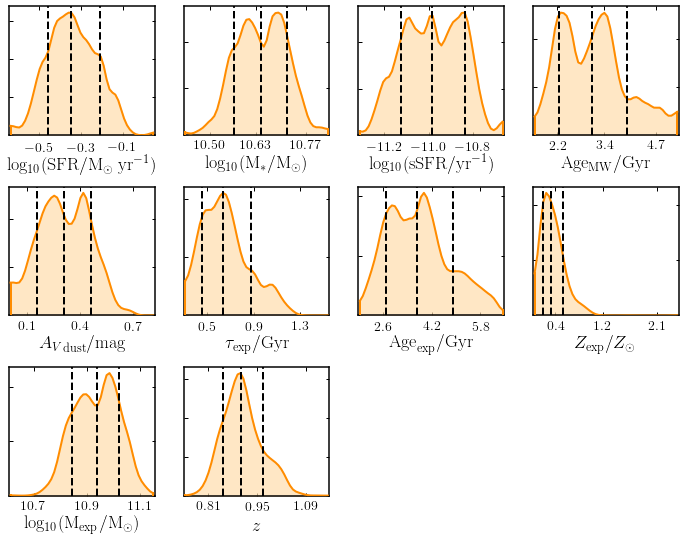

In [10]:
fig = fit.plot_1d_posterior(show=True)

We can also plot the posterior star-formation history:

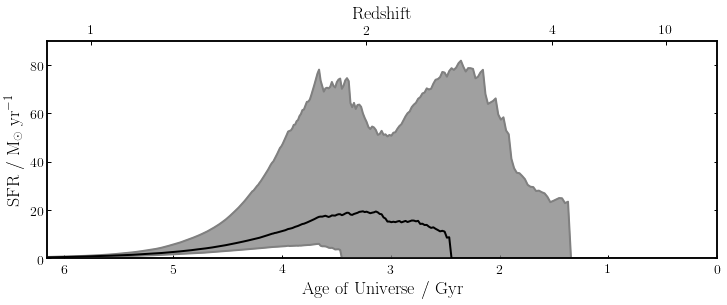

In [11]:
fig = fit.plot_sfh(show=True)

And finally we can make a corner plot of the posterior distribution:

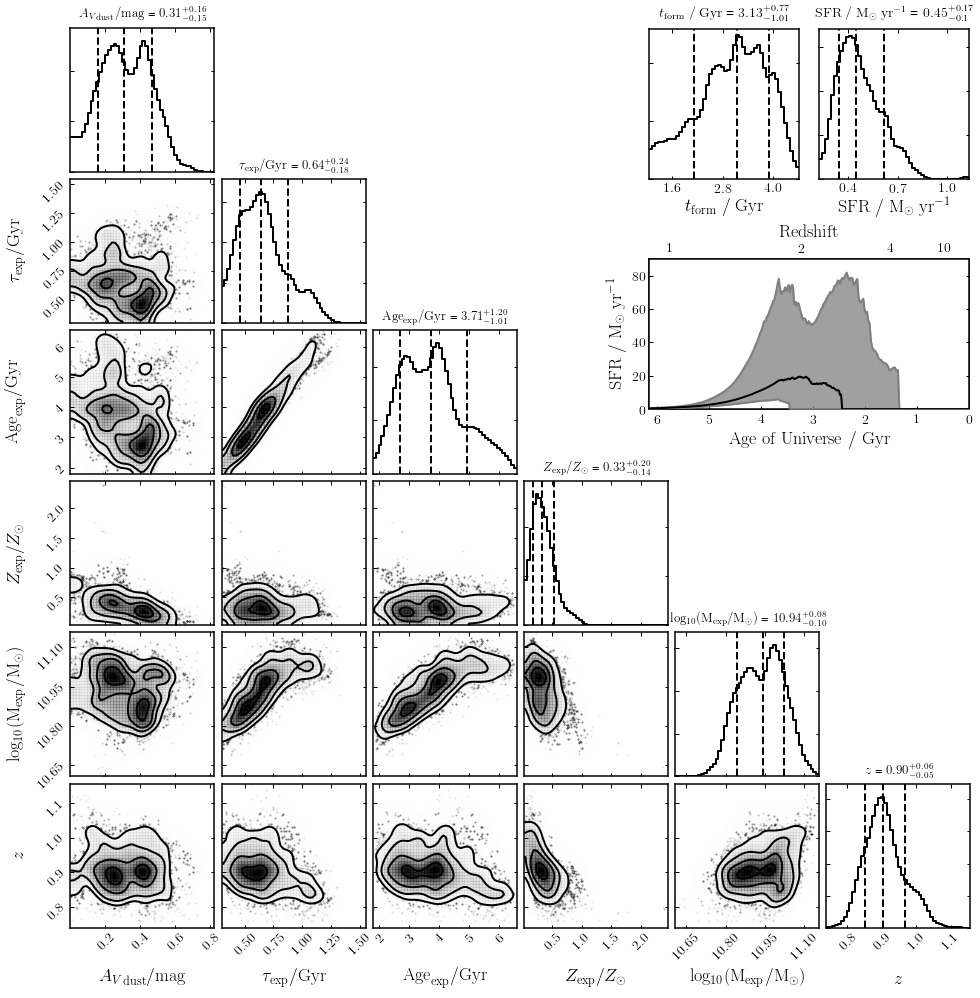

In [12]:
fig = fit.plot_corner(show=True)

By default all of the plots one creates showing the fitting results are saved in the "pipes/plots" directory. 

The plotting interface is designed to be flexible enough that you can generate custom plots of things you want to see without having to start from scratch. The automatic unit parser is coming on pretty nicely as well:

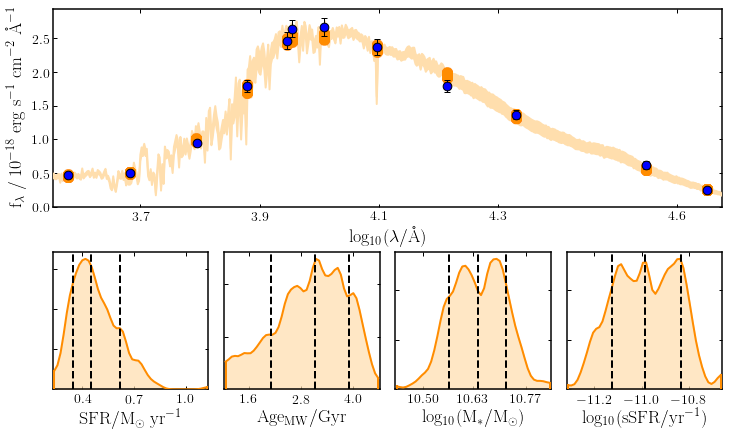

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(figsize=(12, 7))
gs = mpl.gridspec.GridSpec(7, 4, hspace=3., wspace=0.1)

ax1 = plt.subplot(gs[:4, :])

pipes.plotting.add_observed_photometry(fit.galaxy, ax1, zorder=10)
pipes.plotting.add_photometry_posterior(fit, ax1)

post_quantities = [fit.posterior["sfr"],
                   fit.posterior["tmw"],
                   np.log10(fit.posterior["mass"]["total"]["living"]),
                   np.log10(fit.posterior["sfr"]/fit.posterior["mass"]["total"]["living"])]

axis_labels = ["sfr",
               "mwa",
               "mass",
               "ssfr"]

axes = []
for i in range(4):
    axes.append(plt.subplot(gs[4:, i]))
    pipes.plotting.hist1d(post_quantities[i], axes[-1], smooth=True, label=axis_labels[i])

plt.show()


Move on to the next example to see how to fit more complicated models, including imposing priors on your fitting parameters.